In [2]:
import joblib
import os
import nibabel as nib
import numpy as np
from os.path import join as pjoin
from utils import save2cifti

In [3]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline'
model_path = pjoin(wk_dir, 'build/mappings/')
activ_path = pjoin(wk_dir, 'prep/image_activations/')
resp_path = pjoin(wk_dir, 'prep/brain_response/')
gauss_path = pjoin(wk_dir, 'build/gaussianparams')
mask_dir = pjoin(wk_dir,'prep/voxel_masks/')
perform_dir = pjoin(wk_dir, 'anal/test_performance')

## 绘制模型表现图

In [ ]:
performance_mat = np.load(pjoin(perform_dir, 'sub-all_ly-0conv2-1conv2_performance.npy'))


## 计算模型表现 - 批处理

In [8]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline'
model_path = pjoin(wk_dir, 'build/mappings/')
activ_path = pjoin(wk_dir, 'prep/image_activations/')
resp_path = pjoin(wk_dir, 'prep/brain_response/')
gauss_path = pjoin(wk_dir, 'build/gaussianparams')
mask_dir = pjoin(wk_dir,'prep/voxel_masks/')

save_dir = pjoin(wk_dir,'anal/test_performance')


mask_name = 'primaryvis-in-MMP'
primvis_mask = np.squeeze(nib.load(pjoin(mask_dir, f'nod-voxmask_{mask_name}.dlabel.nii')).get_fdata())
primivis_idx = np.where(primvis_mask == 1)[0]

test_set_name = 'coco'


load_model = lambda x : joblib.load(pjoin(model_path, sub, x))
load_activ = lambda x : np.load(pjoin(activ_path, f'{test_set_name}_{x}.npy'))
load_retino = lambda x, y :np.load(pjoin(gauss_path, f'{x}_layer-{y}_Gauss.npy'), allow_pickle=True)[0]
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C


In [9]:
model_name = 'RFmodels'
mask_name = 'subjvis'
net_name = 'googlenet'
layer_names = ['conv2', 'inception3a']
subs = [f'sub-0{_+1}' for _ in range(9)]


In [ ]:
for sub in subs:
    for layer_name in layer_names:
        # load model
        fullmodelname = f'{sub}_bm-{mask_name}_layer-{layer_name}_{model_name}.pkl'
        model = load_model(fullmodelname)
        # determine the shared voxel
        shared_voxel = [ _ for _ in primivis_idx if _ in list(model.keys())]
        # load, reshape and average the resp
        test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
        num_trial = test_resp.shape[0]
        num_run = int(num_trial/120)
        test_resp = test_resp.reshape((num_run, 120, 59412))
        mean_test_resp = test_resp.mean(axis=0)
        # load feature
        test_features = load_activ(layer_name)
        # generate grids
        ii = np.linspace(-8., 8., test_features.shape[-1])
        jj = np.linspace(8., -8., test_features.shape[-1])
        ii, jj = np.meshgrid(ii, jj)
        # load guassian params
        gaussparams = load_retino(sub, layer_name)
        # initialize performance
        performance = []
        # make model prediction
        for voxel in shared_voxel:
            rf = gaussian_2d((ii, jj), *gaussparams[voxel])
            rf = rf / (rf.sum() + 1e-20)
            voxel_test_feature = np.sum(test_features * rf, axis=(2,3)) 
            prediction = model[voxel].predict(voxel_test_feature)
            performance.append(np.corrcoef(prediction, mean_test_resp[:, voxel])[0, 1])
        
        np.save(pjoin(save_dir, f'{sub}-{layer_name}_performance.npy'), performance)
        print(f'saved {sub}-{layer_name}')

## calculate the performance

In [2]:
wk_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline'
model_path = pjoin(wk_dir, 'build/mappings/')
activ_path = pjoin(wk_dir, 'prep/image_activations/')
resp_path = pjoin(wk_dir, 'prep/brain_response/')
gauss_path = pjoin(wk_dir, 'build/gaussianparams')

sub = 'sub-09'
mask_name = 'subjvis'

In [3]:
alexlayer = 'raw-googlenet-conv2'
inceplayer = 'googlenet-conv2'
model_name = 'RFmodels'

alexnetmodelname = f'{sub}_bm-{mask_name}_layer-{alexlayer}_{model_name}.pkl'
googlemodelname = f'{sub}_bm-{mask_name}_layer-{inceplayer}_{model_name}.pkl'

In [4]:
# load models
load_model = lambda x : joblib.load(pjoin(model_path, sub, x))
alexnetmodel = load_model(alexnetmodelname)
googlemodel = load_model(googlemodelname)
len(alexnetmodel.keys()), len(googlemodel.keys())

(4193, 4193)

In [5]:
shared_voxel = list(set(list(googlemodel.keys())) & set(list(alexnetmodel.keys())))


mask_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/voxel_masks/'
mask_name = 'primaryvis-in-MMP'
primvis_mask = np.squeeze(nib.load(pjoin(mask_dir, f'nod-voxmask_{mask_name}.dlabel.nii')).get_fdata())
primivis_idx = np.where(primvis_mask == 1)[0]

selected_voxels =[ _ for _ in primivis_idx if _ in shared_voxel]# list(googlemodel.keys()) 
len(selected_voxels)

4193

In [6]:
test_set_name = 'coco'
test_resp = np.load(pjoin(resp_path, f'{sub}_{test_set_name}_beta.npy'))
num_trial = test_resp.shape[0]
num_run = int(num_trial/120)
test_resp = test_resp.reshape((num_run, 120, 59412))
mean_test_resp = test_resp.mean(axis=0)
mean_test_resp.shape

(120, 59412)

In [7]:
# load features
load_activ = lambda x : np.load(pjoin(activ_path, f'{test_set_name}_{x}.npy'))
if 'raw' in alexlayer:
    alex_activ_suffix = alexlayer.replace('raw-', '') 
    incep_activ_suffix = inceplayer + '_ds'
else:
    alex_activ_suffix = alexlayer
    incep_activ_suffix = inceplayer
test_alexfeature = load_activ(alex_activ_suffix)
test_gglfeature = load_activ(incep_activ_suffix)

In [8]:
test_gglfeature.shape, test_alexfeature.shape

((120, 64, 28, 28), (120, 64, 57, 57))

In [9]:
def gaussian_2d(coords, A, x_0, y_0, sigma_x, sigma_y,C):
    i, j = coords
    return A * np.exp(-((i - x_0)**2 / (2 * sigma_x**2) + (j - y_0)**2 / (2 * sigma_y**2))) + C
# load guassian mask
alex_gaussparams = np.load(pjoin(gauss_path, f'{sub}_layer-{alexlayer}_Gauss.npy'), allow_pickle=True)[0]
ggl_gaussparams = np.load(pjoin(gauss_path, f'{sub}_layer-{inceplayer}_Gauss.npy'), allow_pickle=True)[0]

i_alex = np.linspace(-8., 8., test_alexfeature.shape[-1])
j_alex = np.linspace(8., -8., test_alexfeature.shape[-1])
i_alex, j_alex = np.meshgrid(i_alex, j_alex)

i_ggl = np.linspace(-8., 8., test_gglfeature.shape[-1])
j_ggl = np.linspace(8., -8., test_gglfeature.shape[-1])
i_ggl, j_ggl = np.meshgrid(i_ggl, j_ggl)

In [10]:
# make predictions
alex_performance, ggl_performance = [], []

for voxel in shared_voxel:
    alex_rf = gaussian_2d((i_alex, j_alex), *alex_gaussparams[voxel])
    alex_rf = alex_rf / (alex_rf.sum() + 1e-20)
    voxel_test_alexfeature = np.sum(test_alexfeature * alex_rf, axis=(2,3)) 
    alex_prediction = alexnetmodel[voxel].predict(voxel_test_alexfeature)
    alex_performance.append(np.corrcoef(alex_prediction, mean_test_resp[:, voxel])[0, 1])

    ggl_rf = gaussian_2d((i_ggl, j_ggl), *ggl_gaussparams[voxel])
    ggl_rf = ggl_rf / (ggl_rf.sum() + 1e-20)
    voxel_test_gglfeature = np.sum(test_gglfeature * ggl_rf, axis=(2,3)) 
    ggl_prediction = googlemodel[voxel].predict(voxel_test_gglfeature)
    ggl_performance.append(np.corrcoef(ggl_prediction, mean_test_resp[:, voxel])[0, 1])


In [12]:
np.mean(alex_performance), np.mean(ggl_performance)


(0.027061119235358738, 0.020178848941205616)

In [13]:
save_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/test_performance'
np.save(pjoin(save_dir, f'{sub}_rawretino-{alexlayer}_performance.npy'), alex_performance)
np.save(pjoin(save_dir, f'{sub}_dsxretino-{inceplayer}_performance.npy'), ggl_performance)

In [14]:
# make cross generalize predictions
alex_performance, ggl_performance = [], []

for voxel in shared_voxel:
    alex_rf = gaussian_2d((i_alex, j_alex), *ggl_gaussparams[voxel])
    alex_rf = alex_rf / (alex_rf.sum() + 1e-20)
    voxel_test_alexfeature = np.sum(test_alexfeature * alex_rf, axis=(2,3)) 
    alex_prediction = alexnetmodel[voxel].predict(voxel_test_alexfeature)
    alex_performance.append(np.corrcoef(alex_prediction, mean_test_resp[:, voxel])[0, 1])

    ggl_rf = gaussian_2d((i_ggl, j_ggl), *alex_gaussparams[voxel])
    ggl_rf = ggl_rf / (ggl_rf.sum() + 1e-20)
    voxel_test_gglfeature = np.sum(test_gglfeature * ggl_rf, axis=(2,3)) 
    ggl_prediction = googlemodel[voxel].predict(voxel_test_gglfeature)
    ggl_performance.append(np.corrcoef(ggl_prediction, mean_test_resp[:, voxel])[0, 1])

In [15]:
save_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/test_performance'
np.save(pjoin(save_dir, f'{sub}_dsretino-{alexlayer}_performance.npy'), alex_performance)
np.save(pjoin(save_dir, f'{sub}_rawretino-{inceplayer}_performance.npy'), ggl_performance)

## visualize the performance

In [16]:
performance_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/test_performance'
alexprfmc_files = [_ for _ in sorted(os.listdir(performance_dir)) if 'alexnet' in _]
gglprfmc_files = [_ for _ in sorted(os.listdir(performance_dir)) if 'gglnet' in _]

ggl_performance = np.concatenate([np.load(pjoin(performance_dir, _)) for _ in gglprfmc_files])
alex_performance = np.concatenate([np.load(pjoin(performance_dir, _)) for _ in alexprfmc_files])

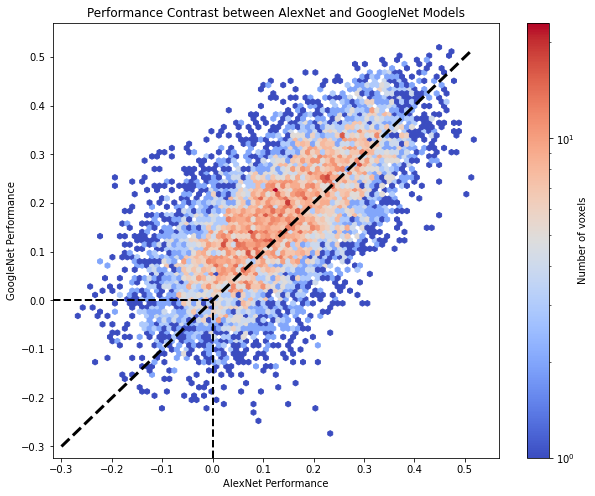

In [8]:
import matplotlib.pyplot as plt

# ggl_performance = np.load(pjoin(performance_dir, f'{sub}_gglnet_performance.npy'))
# alex_performance = np.load(pjoin(performance_dir, f'{sub}_alexnet_performance.npy'))
# 创建散点图
plt.figure(figsize=(10, 8))
# Plot the hexbin graph with actual data and mincnt=1
hb = plt.hexbin(alex_performance, ggl_performance, gridsize=80, cmap='coolwarm', bins='log',mincnt=1)
plt.colorbar(hb, label='Number of voxels')
# Add a line with slope of 1, passing through the origin
plt.plot([-0.3, 0.51], [-0.3, 0.51], color="black", linestyle="--", linewidth=3)
# Add a dashed line parallel to the x-axis at y=0
plt.hlines(0, np.min(alex_performance)-0.05, 0, colors='black', linestyles='--', linewidth=2)
# Add a dashed line parallel to the y-axis at x=0
plt.vlines(0, np.min(ggl_performance)-0.05, 0, colors='black', linestyles='--', linewidth=2)
# Set the axis limits based on the data ranges
plt.xlim(np.min(alex_performance)-0.05, np.max(alex_performance)+0.05)
plt.ylim(np.min(ggl_performance)-0.05, np.max(ggl_performance)+0.05)
# Set labels and title
plt.xlabel('AlexNet Performance')
plt.ylabel('GoogleNet Performance')
plt.title('Performance Contrast between AlexNet and GoogleNet Models')
plt.show()

In [26]:
np.mean(ggl_performance), np.mean(alex_performance), 

(0.14988016740930346, 0.10032258369304535)

In [9]:
gglprfmc_files

['sub-03_gglnet_performance.npy',
 'sub-04_gglnet_performance.npy',
 'sub-05_gglnet_performance.npy',
 'sub-08_gglnet_performance.npy']

In [13]:
mask_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/voxel_masks/'
roi_mask_name = 'primaryvis-in-MMP'
primvis_mask = np.squeeze(nib.load(pjoin(mask_dir, f'nod-voxmask_{roi_mask_name}.dlabel.nii')).get_fdata())
primivis_idx = np.where(primvis_mask == 1)[0]

bfiletemplate = nib.load(pjoin(wk_dir, 'template.dtseries.nii'))
brain_models = bfiletemplate.header.get_index_map(1).brain_models
surface_brain_models = [bm for bm in brain_models if bm.model_type == 'CIFTI_MODEL_TYPE_SURFACE']

performance_bmap = np.nan*np.zeros((len(alexprfmc_files), 59412))
mapnames = []
for isub, (afile, gfile) in enumerate(zip(alexprfmc_files, gglprfmc_files)):
    sub = afile.split('_')[0]
    # load model keyes
    alexnetmodelname = f'{sub}_bm-{mask_name}_layer-{alexlayer}_{model_name}.pkl'
    googlemodelname = f'{sub}_bm-{mask_name}_layer-{inceplayer}_{model_name}.pkl'
    alexnetmodel = load_model(alexnetmodelname)
    googlemodel = load_model(googlemodelname)
    shared_voxel = list(set(list(googlemodel.keys())) & set(list(alexnetmodel.keys())))
    selected_voxels =[ _ for _ in primivis_idx if _ in shared_voxel]
    # load and calc contrast
    performance_bmap[isub, np.array(selected_voxels)] = np.load(pjoin(performance_dir,gfile)) - np.load(pjoin(performance_dir,afile))
    mapnames.append(sub)

map_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/brainmap'
# save on surface|
save2cifti(pjoin(map_dir, f'nod-incp-alex-performance-contrast.dscalar.nii'),  
          performance_bmap, surface_brain_models, map_names=mapnames)



In [43]:
np.load(pjoin(performance_dir,gfile)).shape, gfile

((2584,), 'sub-03_gglnet_performance.npy')

In [17]:
performance_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/test_performance'
ggl_performance = np.load(pjoin(performance_dir, f'{sub}_dsretino-googlenet-conv2_performance.npy'))
alex_performance = np.load(pjoin(performance_dir, f'{sub}_rawretino-raw-googlenet-conv2_performance.npy'))
gglmask_alex_performance = np.load(pjoin(performance_dir, f'{sub}_dsretino-raw-googlenet-conv2_performance.npy'))
alexmask_ggl_performance = np.load(pjoin(performance_dir, f'{sub}_rawretino-googlenet-conv2_performance.npy'))

performances = [[(ggl_performance, alex_performance), (ggl_performance, alexmask_ggl_performance)],
                [(gglmask_alex_performance, alex_performance), (gglmask_alex_performance, alexmask_ggl_performance)]]
labels = [[('dsmask-dsactiv', 'rawmask-rawactiv'), ('dsmask-dsactiv', 'rawmask-dsactiv')],
                [('dsmask-rawactiv', 'rawmask-rawactiv'), ('dsmask-rawactiv', 'rawmask-dsactiv')]]


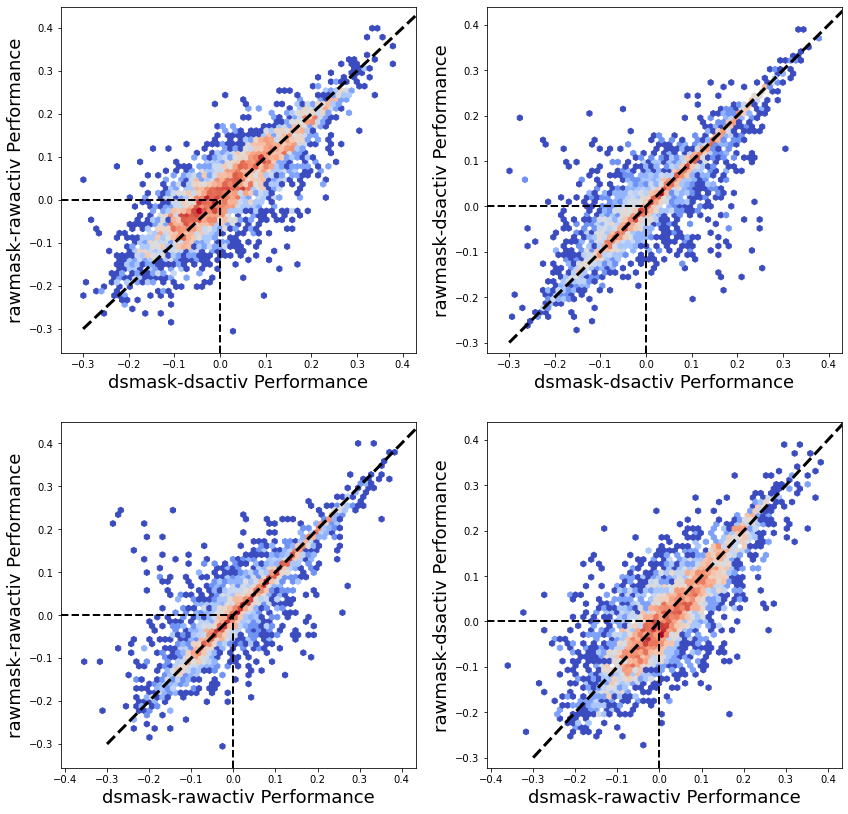

In [19]:
import matplotlib.pyplot as plt

# 创建散点图
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
for i in [0,1]:
    for j in [0,1]:
        # Plot the hexbin graph with actual data and mincnt=1
        x,y = performances[i][j]
        x_label, y_label = labels[i][j]
        hb = axes[i][j].hexbin(x, y, gridsize=60, cmap='coolwarm', bins='log',mincnt=1)
        # axes[i][j].set_colorbar(hb, label='Number of voxels')
        # Add a line with slope of 1, passing through the origin
        axes[i][j].plot([-0.3, 0.51], [-0.3, 0.51], color="black", linestyle="--", linewidth=3)
        # Add a dashed line parallel to the x-axis at y=0
        axes[i][j].hlines(0, np.min(x)-0.05, 0, colors='black', linestyles='--', linewidth=2)
        # Add a dashed line parallel to the y-axis at x=0
        axes[i][j].vlines(0, np.min(y)-0.05, 0, colors='black', linestyles='--', linewidth=2)
        # Set the axis limits based on the data ranges
        axes[i][j].set_xlim(np.min(x)-0.05, np.max(x)+0.05)
        axes[i][j].set_ylim(np.min(y)-0.05, np.max(y)+0.05)
        # Set labels and title
        axes[i][j].set_xlabel(f'{x_label} Performance', fontsize=18)
        axes[i][j].set_ylabel(f'{y_label} Performance', fontsize=18)
        # plt.title('Performance Contrast between AlexNet and GoogleNet Models')
plt.show()

In [20]:
x, y = performances[1][0]
x.mean(), y.mean()

(0.024507684567584936, 0.027061119235358738)

## 在初级皮层内考察tuning similarity 

In [140]:
import nibabel as nib
mask_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/voxel_masks/'
mask_name = 'primaryvis-in-MMP'
primvis_mask = np.squeeze(nib.load(pjoin(mask_dir, f'nod-voxmask_{mask_name}.dlabel.nii')).get_fdata())
primivis_idx = np.where(primvis_mask == 1)[0]

selected_voxels =[ _ for _ in primivis_idx if _ in shared_voxel]# list(googlemodel.keys()) 

In [141]:
sim_save_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/anal/voxel-tuning-similarity'
alex_weights = np.stack([alexnetmodel[voxel].coef_ for voxel in selected_voxels])
ggl_weights = np.stack([googlemodel[voxel].coef_ for voxel in selected_voxels])
ggl_sim = np.corrcoef(ggl_weights)
ggl_sim.shape

(2668, 2668)

In [83]:
np.save(pjoin(sim_save_dir, f'{sub}_bm-{mask_name}_layer-{inceplayer}_tuningsim.npy'), ggl_sim)

In [143]:
(ggl_weights[0:3, 0:6])

array([[-0.17903362, -0.09098457, -1.68711603, -0.24129321, -0.00739639,
        -0.13093708],
       [-0.11790058, -0.29332342, -1.38822106, -0.81503511, -0.31516292,
         0.08484774],
       [ 0.27248981, -0.31790998, -1.53814269, -0.34133101, -0.44904041,
         0.01037921]])